# Protein Complexes in Ovarian Cancer

### Run Analysis_Functions.ipynb to make its imports and functions available in this notebook

In [119]:
%run Analysis_Functions.ipynb

Checking that data files are up-to-date...

Data check complete.
ovarian data version: Most recent release

Loading clinical data...
Loading cnv data...
Loading definitions data...
Loading phosphoproteomics data...
Loading proteomics data...
Loading somatic_38 data...
Loading transcriptomics data...
Loading treatment data...
11


### Test all protein complexes for differences in mean (ratios) using a t-test

In [21]:
complex_types = test_all_complexes()

PSMD12 / PSMC6: 4.0700194370717815e-13
PSMD12 / PSMD2: 1.7554832411980443e-09
PSMC3 / PSMC6: 3.830136602362548e-09
PA700 complex
---------------------------
---------------------------
SMARCB1 / ACTB: 2.0058570224489942e-09
SMARCC2 / ACTB: 2.65542424702679e-09
SMARCE1 / ACTB: 2.4846259145603956e-13
SCYL1 / ACTB: 5.76402836134157e-14
NUMAC complex (nucleosomal methylation activator complex)
---------------------------
---------------------------
NAA15 / XRCC6: 5.417384104576672e-09
Ku antigen-NARG1 complex
---------------------------
---------------------------
ACTL6A / ACTB: 1.9058944492564406e-10
SMARCB1 / ACTB: 2.0058570224489942e-09
SMARCC2 / ACTB: 2.65542424702679e-09
SMARCE1 / ACTB: 2.4846259145603956e-13
PBAF complex (Polybromo- and BAF containing complex)
---------------------------
---------------------------
NDUFS4 / NDUFA8: 1.0261478743489265e-09
Respiratory chain complex I (holoenzyme), mitochondrial
---------------------------
---------------------------
PSMC3 / PSMC6: 3.83

U2AF1 / HNRNPC: 4.6754788087859064e-09
U2AF1 / HNRNPA2B1: 4.600708478778491e-09
U2AF1 / HNRNPA3: 3.822258183253968e-09
U2AF1 / HNRNPM: 4.833336103449626e-10
U2AF1 / HNRNPK: 4.0079779840856145e-10
SF3B2 / HNRNPC: 1.7829057531297318e-12
SF3B2 / HNRNPA2B1: 3.4006549887574977e-09
SF3B2 / HNRNPM: 5.502688425204818e-12
SF3B2 / HNRNPK: 7.773775653303268e-10
PRPF4B / HNRNPA3: 4.071879901817516e-09
SNW1 / SYNCRIP: 2.4920226841692403e-09
SNW1 / SF3B1: 5.1041028234958315e-12
SNW1 / HNRNPC: 6.290213739800418e-12
SNW1 / HNRNPA1: 2.051928082516933e-10
SNW1 / PABPC1: 8.856701619091757e-11
SNW1 / HNRNPA2B1: 2.4991812256581323e-13
SNW1 / HNRNPH1: 1.4686534579028828e-13
SNW1 / HNRNPA3: 2.740654811625982e-10
SNW1 / HNRNPM: 8.518047142093433e-14
SNW1 / HNRNPK: 2.245326904325848e-09
SNW1 / HNRNPU: 2.915218734354299e-11
EFTUD2 / HNRNPK: 9.22321216026426e-11
SF3B3 / HNRNPK: 7.709012430816952e-10
PRPF8 / SF3B1: 9.805576056543689e-10
PRPF8 / HNRNPC: 1.754657338436712e-10
PRPF8 / HNRNPA2B1: 1.3922093599344061e-

DNA-PK-Ku-eIF2-NF90-NF45 complex
---------------------------
---------------------------
TP53BP1 / XRCC6: 5.52902573495514e-11
53BP1-containing complex
---------------------------
---------------------------
TXLNA / HSP90AB1: 3.303431568467729e-09
TNF-alpha/NF-kappa B signaling complex 10
---------------------------
---------------------------
RPL27 / RPL12: 4.262616712915058e-12
RPL30 / RPL12: 1.7674821437714092e-09
RPL32 / RPL12: 1.0971240261617066e-09
TRBP containing complex (DICER, RPL7A, EIF6, MOV10 and subunits of the 60S ribosomal particle)
---------------------------
---------------------------
WDR5 / RUVBL1: 2.604081736057362e-09
MLL1-WDR5 complex
---------------------------
---------------------------
SPTAN1 / MYH9: 6.957856748452747e-10
Emerin complex 1
---------------------------
---------------------------
LMNB1 / SPTAN1: 2.780290949007122e-09
Emerin architectural complex
---------------------------
---------------------------
LMNA / LMNB1: 1.842308822353785e-10
LMNA / HNR

In [24]:
complex_types['Other']

['PA700 complex',
 'NUMAC complex (nucleosomal methylation activator complex)',
 'Ku antigen-NARG1 complex',
 'PBAF complex (Polybromo- and BAF containing complex)',
 'Respiratory chain complex I (holoenzyme), mitochondrial',
 '26S proteasome',
 'BAF complex',
 '20S proteasome',
 'PA28-20S proteasome',
 'PA700-20S-PA28 complex',
 'PA28gamma-20S proteasome',
 '40S ribosomal subunit, cytoplasmic',
 'Ribosome, cytoplasmic',
 '60S ribosomal subunit, cytoplasmic',
 'DNA-PK-Ku complex',
 'Spliceosome',
 'Prolyl 4-hydroxylase (alpha(I)-type)',
 'CSA-POLIIa complex',
 'LARC complex (LCR-associated remodeling complex)',
 'Toposome',
 'CEN complex',
 'CF IIAm complex (Cleavage factor IIAm complex)',
 'C complex spliceosome',
 'CDC5L core complex',
 'CDC5L complex',
 'H2AX complex, isolated from cells without IR exposure',
 'FIB-associated protein complex',
 'SNW1 complex',
 'Vigilin-DNA-PK-Ku antigen complex',
 'TLE1 corepressor complex (MASH1 promoter-corepressor complex)',
 'SMN-PolII-RHA comp

### Test all protein complexes for differences in variance (ratios) using a levene test

In [25]:
var_complex_types = test_all_complexes(test_type = 'levene')

/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/scipy/stats/morestats.py:1969: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


PSMD4 / PSMC3: 1.436022584493798e-09
PA700 complex
---------------------------
---------------------------
PSMD4 / PSMC3: 1.436022584493798e-09
PA700-20S-PA28 complex
---------------------------
---------------------------
Normal missing RPS28 / RPS2
RPS28 / RPS2: 5.784111698282765e-10
Normal missing RPS28 / RPS3
RPS28 / RPS3: 1.9297798087103064e-09
40S ribosomal subunit, cytoplasmic
---------------------------
---------------------------
Normal missing RPS29 / RPL12
RPS29 / RPL12: 3.7563864438129136e-10
Normal missing RPS28 / RPS2
RPS28 / RPS2: 5.784111698282765e-10
Normal missing RPS28 / RPS3
RPS28 / RPS3: 1.9297798087103064e-09
Normal missing RPS28 / RPL6
RPS28 / RPL6: 1.959766090213786e-09
Normal missing RPL36A / RPS2
RPL36A / RPS2: 1.211284866026019e-09
Normal missing RPL36A / RPS4Y1
RPL36A / RPS4Y1: 1.434126010923186e-09
Normal missing RPL36A / RPS4X
RPL36A / RPS4X: 1.434126010923186e-09
Normal missing RPL36A / RPL6
RPL36A / RPL6: 3.892510840246498e-10
Ribosome, cytoplasmic
-----

In [16]:
var_complex_types['Normal Missing Proteins']

['40S ribosomal subunit, cytoplasmic',
 'Ribosome, cytoplasmic',
 '60S ribosomal subunit, cytoplasmic',
 'Spliceosome',
 'NuA4/Tip60-HAT complex',
 'NuA4/Tip60-HAT complex A',
 'Toposome',
 'CEN complex',
 'Large Drosha complex',
 'Nop56p-associated pre-rRNA complex',
 'GSK3B-HSP90AA1-PKM2 complex']

### Plots of individual ratios

T-test result: 1.0319163449891081e-10
Levene test result: 0.09309832022384429


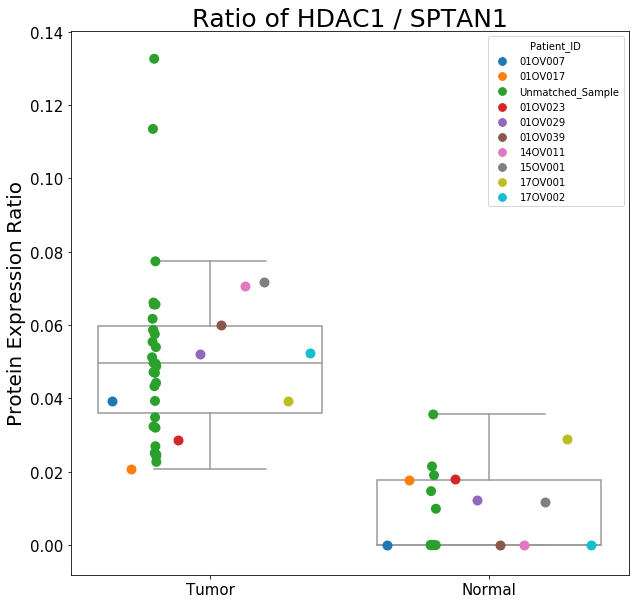

In [121]:
plot_ratios('HDAC1', 'SPTAN1', by_patient = True)

T-test result: 1.577374719232943e-05
Levene test result: 4.469273426574101e-10


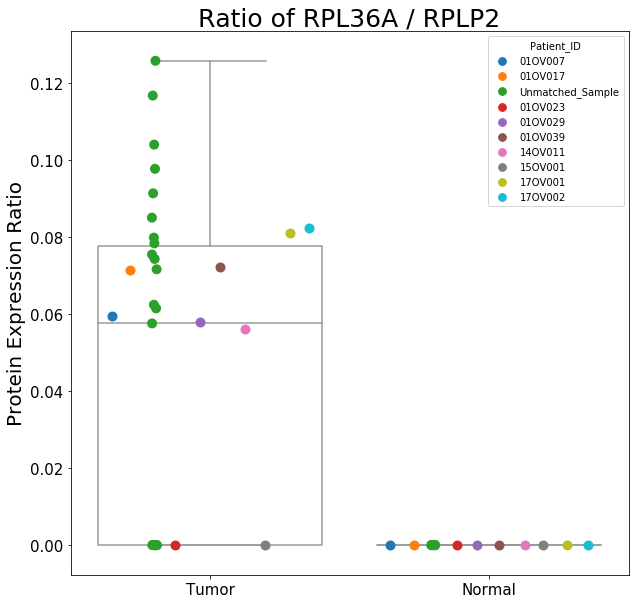

In [67]:
plot_ratios('RPL36A', 'RPLP2', by_patient = True)

T-test result: 4.0700194370717815e-13
Levene test result: 0.0002052976972771812


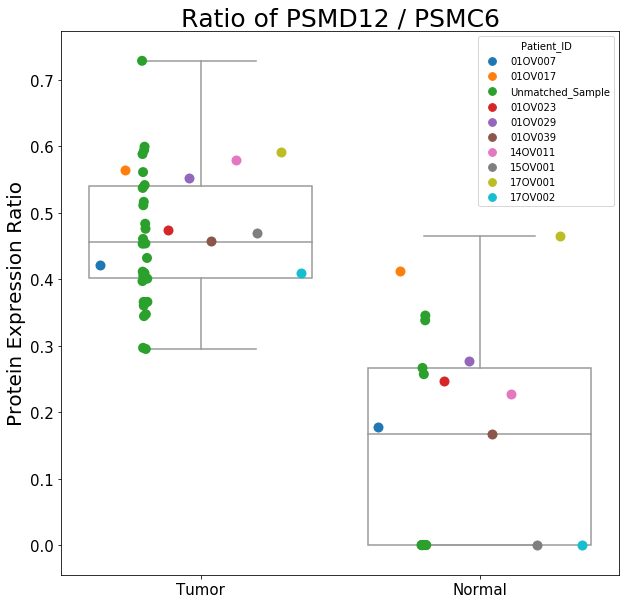

In [78]:
plot_ratios('PSMD12', 'PSMC6', by_patient=True)

## Include mutational data

In [107]:
find_mutations(complex_types)

Normal Missing Proteins
--------------
--------------
Tumor Missing Proteins
--------------
--------------
Other
--------------
--------------


/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


PA700 complex
{'PSMD4': 1}
--------------
NUMAC complex (nucleosomal methylation activator complex)
{'SMARCB1': 1}
--------------
Ku antigen-NARG1 complex
{'NAA15': 2}
--------------
PBAF complex (Polybromo- and BAF containing complex)
{'SMARCB1': 1}
--------------
26S proteasome
{'PSMC4': 1, 'PSMD4': 1}
--------------
BAF complex
{'SMARCB1': 1}
--------------
PA700-20S-PA28 complex
{'PSMD4': 1, 'PSMD1': 3, 'PSMC4': 1}
--------------


/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/scipy/stats/morestats.py:1969: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


40S ribosomal subunit, cytoplasmic
{'RPS2': 2}
--------------
Ribosome, cytoplasmic
{'RPL27': 3, 'RPS2': 2, 'RPL30': 1}
--------------
60S ribosomal subunit, cytoplasmic
{'RPL27': 3, 'RPL30': 1}
--------------
DNA-PK-Ku complex
{'PRKDC': 10}
--------------
Spliceosome
{'PUF60': 1, 'PRPF8': 1, 'AQR': 1, 'U2AF1': 1, 'SRRM2': 2, 'SNW1': 1, 'LUC7L3': 1, 'PRPF40A': 2, 'DDX46': 1, 'SNRPA1': 1, 'SNRPC': 2, 'SRRT': 2, 'PRPF3': 1, 'WTAP': 1, 'DDX23': 1, 'BCAS2': 1}
--------------
Prolyl 4-hydroxylase (alpha(I)-type)
{'P4HA1': 1}
--------------
CSA-POLIIa complex
{'POLR2A': 3}
--------------
LARC complex (LCR-associated remodeling complex)
{'CHD4': 5, 'SMARCD2': 1, 'MBD3': 1, 'SMARCB1': 1, 'MTA2': 1}
--------------
Toposome
{'SRPK1': 2, 'DDX21': 1, 'PRPF8': 1}
--------------
CEN complex
{'WTAP': 1, 'SRRT': 2}
--------------
CF IIAm complex (Cleavage factor IIAm complex)
{'CAPRIN1': 4}
--------------
C complex spliceosome
{'PRPF4B': 3, 'SNW1': 1, 'PRPF8': 1, 'EFTUD2': 1, 'SNRNP200': 1, 'AQR': 1, 

In [108]:
find_mutations(var_complex_types)

Normal Missing Proteins
--------------
--------------


/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/scipy/stats/morestats.py:1969: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


40S ribosomal subunit, cytoplasmic
{'RPS2': 2}
--------------
Ribosome, cytoplasmic
{'RPL27': 3, 'RPS2': 2, 'RPL30': 1}
--------------
60S ribosomal subunit, cytoplasmic
{'RPL27': 3, 'RPL30': 1}
--------------
Spliceosome
{'PUF60': 1, 'PRPF8': 1, 'AQR': 1, 'U2AF1': 1, 'SRRM2': 2, 'SNW1': 1, 'LUC7L3': 1, 'PRPF40A': 2, 'DDX46': 1, 'SNRPA1': 1, 'SNRPC': 2, 'SRRT': 2, 'PRPF3': 1, 'WTAP': 1, 'DDX23': 1, 'BCAS2': 1}
--------------
Toposome
{'SRPK1': 2, 'DDX21': 1, 'PRPF8': 1}
--------------
Large Drosha complex
{'SRPK1': 2}
--------------
Nop56p-associated pre-rRNA complex
{'RPL27': 3, 'TUBA1A': 2, 'RBM28': 3, 'U2AF1': 1, 'RSL1D1': 1, 'DDX21': 1, 'ILF2': 1, 'SRPK1': 2, 'NCL': 1, 'NAP1L1': 2, 'DHX9': 4, 'LYAR': 2, 'RPS2': 2, 'RPL30': 1}
--------------
Tumor Missing Proteins
--------------
--------------
Other
--------------
--------------
PA700 complex
{'PSMD4': 1}
--------------
PA700-20S-PA28 complex
{'PSMD4': 1, 'PSMD1': 3, 'PSMC4': 1}
--------------
CEN complex
{'WTAP': 1, 'SRRT': 2}
----

In [110]:
find_mutations(complex_types, transcription_factors = True)

Normal Missing Proteins
--------------
--------------
Tumor Missing Proteins
--------------
--------------
Other
--------------
--------------


/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


NUMAC complex (nucleosomal methylation activator complex)
{'PARP1 (regulates SMARCB1)': 1}
--------------
PBAF complex (Polybromo- and BAF containing complex)
{'PARP1 (regulates SMARCB1)': 1}
--------------
BAF complex
{'PARP1 (regulates SMARCB1)': 1}
--------------


/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/scipy/stats/morestats.py:1969: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


Spliceosome
{'WT1 (regulates WTAP)': 1, 'ESRRB (regulates BCAS2)': 2}
--------------
Prolyl 4-hydroxylase (alpha(I)-type)
{'SP1 (regulates P4HA1)': 1, 'USF1 (regulates P4HA1)': 1, 'USF2 (regulates P4HA1)': 3}
--------------
LARC complex (LCR-associated remodeling complex)
{'PARP1 (regulates SMARCB1)': 1}
--------------
CEN complex
{'WT1 (regulates WTAP)': 1}
--------------
CDC5L core complex
{'ESRRB (regulates BCAS2)': 2}
--------------
CDC5L complex
{'SF1 (regulates SF3B1)': 3, 'ESRRB (regulates BCAS2)': 2}
--------------
FIB-associated protein complex
{'PIAS1 (regulates PRMT1)': 1}
--------------
SNW1 complex
{'DNMT1 (regulates MSH2)': 3, 'NF1 (regulates MSH2)': 4}
--------------
Nop56p-associated pre-rRNA complex
{'MYBL2 (regulates NCL)': 2}
--------------
Emerin complex 32
{'PARP1 (regulates SMARCB1)': 1, 'DNMT1 (regulates HDAC1)': 3, 'EZH2 (regulates HDAC1)': 1, 'FLI1 (regulates HDAC1)': 2, 'MTA1 (regulates HDAC1)': 2, 'NFKB1 (regulates HDAC1)': 1, 'RELA (regulates HDAC1)': 2, 'RF

In [111]:
find_mutations(var_complex_types, transcription_factors = True)

Normal Missing Proteins
--------------
--------------


/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/anaconda3/envs/ptmresearch/lib/python3.7/site-packages/scipy/stats/morestats.py:1969: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


Spliceosome
{'WT1 (regulates WTAP)': 1, 'ESRRB (regulates BCAS2)': 2}
--------------
Nop56p-associated pre-rRNA complex
{'MYBL2 (regulates NCL)': 2}
--------------
GSK3B-HSP90AA1-PKM2 complex
{'CDX2 (regulates GSK3B)': 1, 'CREB1 (regulates GSK3B)': 2, 'NFKB1 (regulates GSK3B)': 1, 'TFCP2 (regulates GSK3B)': 4}
--------------
Tumor Missing Proteins
--------------
--------------
Other
--------------
--------------
CEN complex
{'WT1 (regulates WTAP)': 1}
--------------


In [120]:
find_unique_mutations(['DNMT1', 'EZH2', 'FLI1', 'MTA1', 'NFKB1', 'RELA', 'RFX1', 'SATB1'])

11


['04OV013',
 '04OV057',
 '01OV007',
 '11OV002',
 '04OV024',
 '04OV063',
 '04OV044',
 '02OV005',
 '04OV048',
 '17OV002',
 '04OV001']

T-test result: 1.0319163449891081e-10
Levene test result: 0.09309832022384429


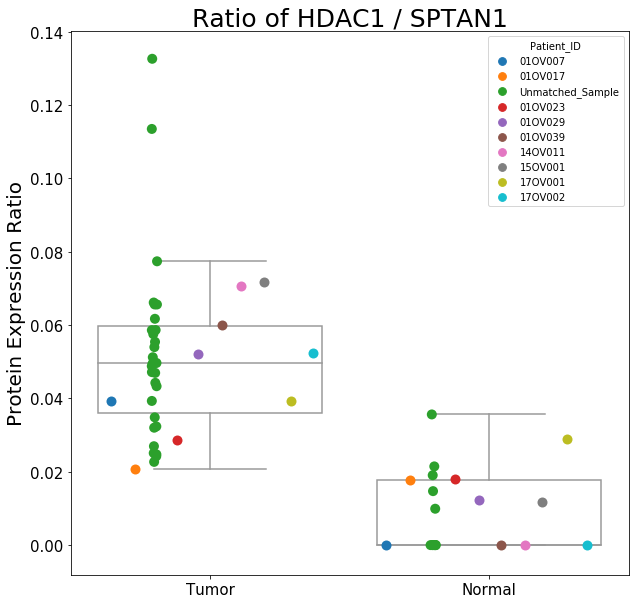

In [122]:
plot_ratios('HDAC1', 'SPTAN1', by_patient = True)